<a href="https://colab.research.google.com/github/ZahraHomayonfar/Clock/blob/main/Clock_ZahraHomayonfar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose is to identify the time based on the image received from the user. The image is a clock that shows a specific time and minute. You need to write code that train a deep learning neural network based on the dataset images, then use the test data to measure the accuracy of the model,finally, give a sample image to the model and specify the time. 

**1.Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**2.Install tensorflow**

In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**3.Import libraries**

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, Activation, AveragePooling2D , Dropout, Input, BatchNormalization
import tensorflow as tf

**4.Create a function for the model**

In [ ]:
def ConvolutionalNeuralNetwork_Model():

    inp_model = Input(shape=(100, 100, 1))

    ##convolution and pooling layers
    p = Conv2D(40, kernel_size=5, strides=1, activation='relu')(inp_model)
    p = AveragePooling2D(pool_size=(2, 2), strides=2)(p)
    p = BatchNormalization()(p)

    p = Conv2D(80, kernel_size=3, strides=1, activation='relu')(p)
    p = AveragePooling2D(pool_size=(2, 2))(p)
    p = BatchNormalization()(p)

    p = Conv2D(120, kernel_size=3, strides=1, activation='relu')(p)
    p = AveragePooling2D(pool_size=(2, 2))(p)
    p = BatchNormalization()(p)

    p = Conv2D(160, kernel_size=3, strides=1, activation='relu')(p)
    p = AveragePooling2D(pool_size=(2, 2))(p)
    p = BatchNormalization()(p)

    p = Conv2D(200, kernel_size=3, strides=1, activation='relu')(p)
    p = Dropout(.4)(p)

    p = Flatten()(p)

    ##dense layers for hour
    hour = Dense(144, activation='relu')(p)
    hour = Dense(144, activation='relu')(hour)
    hour = Dense(12, activation='softmax', name='hour')(hour)

    ##dense layers for minute
    minute = Dense(100, activation='relu')(p)
    minute = Dense(200, activation='relu')(minute)
    minute = Dense(60, activation='linear', name='minute')(minute)

    model = Model(inputs=inp_model, outputs=[hour, minute])

    return model

**5.Create a function for pre-processing images**

In [ ]:
def preprocess(im):
    
    im = im/255
    im -= .5
    return im

**6.Create a function for load date batch**

In [ ]:
def load_data_batch(ImageDS, batch_size=32, channel=1, im_size=100, path='data'):

    data = pd.read_csv(path + '/label.csv')
    path = path + '/images/'

    image_batch = np.zeros((batch_size, im_size, im_size, channel))   
    label_hour = np.zeros((batch_size, 1))
    label_min = np.zeros((batch_size, 1))
    batch = np.random.choice(ImageDS, batch_size)
    
    j = 0
    for i in range(len(batch)):
        
        im = Image.open(path + str(batch[i]) + '.jpg').convert('L') 
        ##Syntax: Image.convert(mode=None, matrix=None, dither=None, palette=0, colors=256)
        ##dither – Dithering method, used when converting from mode “RGB” to “P” or from “RGB” or “L” to “1”. Available methods are NONE or FLOYDSTEINBERG (default).
            
        im = im.resize((im_size,im_size), Image.ANTIALIAS)
        im = np.array(im)
        
        image_batch[j] = preprocess(im).reshape((im_size, im_size, channel))
        label_hour[j] = (data['hour'][data.index==batch[i]])
        label_min[j] = (data['minute'][data.index==batch[i]])/60
        j += 1
          
    return (np.array(image_batch), np.array(label_hour), np.array(label_min))

**7.Create a function for predict**

In [ ]:
def predict(ind):        
        
    im = Image.open(im_path + str(ind) + '.jpg')
    plt.imshow(im)
    print('Input image:')
    plt.show()
    im = im.convert('L')
    im = im.resize((im_size,im_size), Image.ANTIALIAS)
    im = np.array(im)
    im = preprocess(im).reshape((1, im_size, im_size, channel))
    time = model.predict(im)
    hour = np.argmax(time[0])
    minute = int(time[1][0][0]*60)
    print('Predicted Time:', str(hour)+':'+str(minute))

**8.Give values to variables**

In [ ]:
channel = 1
im_size = 100
path = '/content/gdrive/My Drive/Clock'
im_path = path + '/images/'

**9. Use load data batch function for our data**

In [ ]:
train_size = 10000 ##The total number of database samples is 50,000
test_size = 1000

train = np.arange(train_size)
test = np.arange(test_size) 

x_train, y1_train, y2_train = load_data_batch(train, len(train), channel, im_size, path )
x_test, y1_test, y2_test = load_data_batch(test, len(test), channel, im_size, path )

**10.Fitting model**

In [ ]:
model = ConvolutionalNeuralNetwork_Model()

adam = tf.keras.optimizers.Adam(lr=.0001)
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer=adam, metrics=['accuracy', 'mae'])

model.fit(x_train, [y1_train, y2_train], epochs=1, batch_size=256, validation_data=(x_test, [y1_test, y2_test]))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [==============================] - 265s 7s/step - loss: 2.8835 - hour_loss: 2.5594 - minute_loss: 0.3241 - hour_accuracy: 0.0899 - hour_mae: 5.4090 - minute_accuracy: 1.0000e-04 - minute_mae: 0.4573 - val_loss: 2.7648 - val_hour_loss: 2.4870 - val_minute_loss: 0.2778 - val_hour_accuracy: 0.0890 - val_hour_mae: 5.5230 - val_minute_accuracy: 0.0000e+00 - val_minute_mae: 0.4483


**11.Prediction for one sample**

Input image:


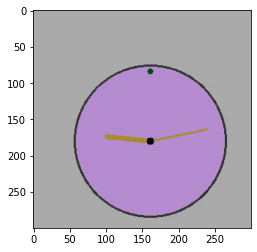

Predicted Time: 10:3


In [ ]:
predict(test[28])

https://colab.research.google.com/drive/16kdCvxfOrG08ocHMttJABdetI3Kk4F7k?usp=sharing